In [1]:
import nfl_data_py as nfl
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.cluster import KMeans

C:\Users\wpous\miniconda3\envs\ffproj\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [37]:
from matplotlib import style
style.use("ggplot")

In [48]:
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

In [38]:
nfl.see_pbp_cols()

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'out_of_bounds', 'home_opening_kickoff', 'qb_epa', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd',
       'xpass', 'pass_oe'],
      dtype='object', length=372)

In [ ]:
pbp2021 = nfl.import_pbp_data([2021])
players2021 = nfl.import_rosters([2021])

2021 done.
Downcasting floats.


In [2]:
yrs = [2014 + i for i in range(8)]
print(yrs)

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [3]:
pbp_multyears = nfl.import_pbp_data(yrs)
players_multyears = nfl.import_rosters(yrs)

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


In [ ]:
pbp_multyears['spread_line']

0         3.5
1         3.5
2         3.5
3         3.5
4         3.5
         ... 
147255   -4.5
147256   -4.5
147257   -4.5
147258   -4.5
147259   -4.5
Name: spread_line, Length: 147260, dtype: float32

In [ ]:
list(pbp.columns)

In [ ]:
pbp2021['name']

0               None
1               None
2            D.Henry
3        R.Tannehill
4        R.Tannehill
            ...     
50707       S.Perine
50708           None
50709       J.Burrow
50710     M.Stafford
50711           None
Name: name, Length: 50712, dtype: object

In [ ]:
pbp2021.groupby(['week', 'game_date', 'defteam'], as_index=False).agg({'passing_yards': 'sum', 'pass_touchdown':'sum', 'complete_pass': 'sum', 'receiving_yards': 'sum', 'touchdown':'sum', 'rushing_yards': 'sum', 'sack':'sum', 'interception':'sum', 'fumble_lost': 'sum'})


,week,game_date,defteam,passing_yards,pass_touchdown,complete_pass,receiving_yards,touchdown,rushing_yards,sack,interception,fumble_lost
0,1,2021-09-09,DAL,379.0,4.0,32.0,379.0,4.0,52.0,0.0,2.0,2.0
1,1,2021-09-09,TB,403.0,3.0,42.0,403.0,3.0,60.0,1.0,1.0,0.0
2,1,2021-09-12,ARI,218.0,1.0,22.0,218.0,2.0,86.0,6.0,1.0,2.0
3,1,2021-09-12,ATL,264.0,3.0,27.0,264.0,4.0,173.0,1.0,0.0,0.0
4,1,2021-09-12,BUF,188.0,1.0,18.0,188.0,1.0,75.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
565,21,2022-01-30,KC,250.0,2.0,23.0,250.0,2.0,116.0,1.0,1.0,0.0
566,21,2022-01-30,LA,232.0,2.0,16.0,232.0,2.0,50.0,0.0,1.0,0.0
567,21,2022-01-30,SF,337.0,2.0,31.0,337.0,2.0,70.0,2.0,1.0,0.0
568,22,2022-02-13,CIN,283.0,3.0,26.0,283.0,3.0,43.0,2.0,2.0,0.0


In [ ]:
passers2021 = pbp2021.groupby(['passer_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], as_index = False).agg({'passing_yards': 'sum', 'pass_touchdown':'sum'}).rename(columns = {'pass_touchdown': 'passing_tds'})
receivers2021 = pbp2021.groupby(['receiver_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], as_index = False).agg({'complete_pass': 'sum', 'receiving_yards': 'sum', 'touchdown':'sum'}).rename(columns = {'complete_pass': 'receptions', 'touchdown': 'receiving_tds'})
rushers2021 = pbp2021.groupby(['rusher_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], as_index = False).agg({'rushing_yards': 'sum', 'touchdown':'sum'}).rename(columns = {'touchdown': 'rushing_tds'})

In [ ]:
passers2021 = passers2021.merge(players2021[["player_id", "player_name"]], left_on="passer_id", right_on="player_id").drop(columns = 'passer_id')
receivers2021 = receivers2021.merge(players2021[["player_id", "player_name"]], left_on="receiver_id", right_on="player_id").drop(columns = 'receiver_id')
rushers2021 = rushers2021.merge(players2021[["player_id", "player_name"]], left_on="rusher_id", right_on="player_id").drop(columns = 'rusher_id')

In [ ]:
receivers2021

,week,game_date,spread_line,total_line,possession_team,home_team,receptions,receiving_yards,receiving_tds,player_id,player_name
0,3,2021-09-26,3.5,50.5,GB,SF,1.0,-4.0,0.0,00-0023459,Aaron Rodgers
1,1,2021-09-12,-4.0,49.0,GB,NO,1.0,19.0,0.0,00-0024243,Marcedes Lewis
2,4,2021-10-03,6.5,45.0,GB,GB,1.0,7.0,0.0,00-0024243,Marcedes Lewis
3,5,2021-10-10,-2.0,50.0,GB,CIN,2.0,34.0,0.0,00-0024243,Marcedes Lewis
4,7,2021-10-24,8.5,48.0,GB,GB,3.0,31.0,0.0,00-0024243,Marcedes Lewis
...,...,...,...,...,...,...,...,...,...,...,...
4475,12,2021-11-28,-2.5,47.5,LAC,DEN,0.0,0.0,0.0,00-0037011,Tre' McKitty
4476,15,2021-12-16,-3.0,54.0,LAC,LAC,1.0,4.0,0.0,00-0037011,Tre' McKitty
4477,16,2021-12-26,-13.5,46.0,LAC,HOU,1.0,12.0,0.0,00-0037011,Tre' McKitty
4478,17,2022-01-02,8.0,45.5,LAC,LAC,3.0,22.0,0.0,00-0037011,Tre' McKitty


In [ ]:
passers2021[passers2021['passer'] == 'T.Brady']

In [ ]:
rushers2021[rushers2021['player_name'] == 'Justin Jefferson']

,week,rushing_yards,rushing_tds,player_id,player_name
1819,9,11.0,0.0,00-0036322,Justin Jefferson
1820,10,-4.0,0.0,00-0036322,Justin Jefferson
1821,11,3.0,0.0,00-0036322,Justin Jefferson
1822,13,4.0,0.0,00-0036322,Justin Jefferson
1823,14,-4.0,0.0,00-0036322,Justin Jefferson
1824,18,4.0,0.0,00-0036322,Justin Jefferson


In [ ]:
receivers2021[receivers2021['player_name'] == 'Justin Jefferson']

,week,spread_line,total_line,possession_team,home_team,receptions,receiving_yards,receiving_tds,player_id,player_name
3689,1,-3.0,47.0,MIN,CIN,5.0,71.0,0.0,00-0036322,Justin Jefferson
3690,2,4.0,51.0,MIN,ARI,6.0,65.0,1.0,00-0036322,Justin Jefferson
3691,3,-2.0,53.5,MIN,MIN,9.0,118.0,1.0,00-0036322,Justin Jefferson
3692,4,-1.0,52.0,MIN,MIN,6.0,84.0,1.0,00-0036322,Justin Jefferson
3693,5,10.0,49.5,MIN,MIN,7.0,124.0,0.0,00-0036322,Justin Jefferson
3694,6,-2.5,45.5,MIN,CAR,8.0,80.0,0.0,00-0036322,Justin Jefferson
3695,8,4.5,49.5,MIN,MIN,2.0,21.0,0.0,00-0036322,Justin Jefferson
3696,9,7.5,51.0,MIN,BAL,3.0,69.0,1.0,00-0036322,Justin Jefferson
3697,10,3.0,53.5,MIN,LAC,9.0,143.0,0.0,00-0036322,Justin Jefferson
3698,11,-1.0,48.0,MIN,MIN,8.0,169.0,2.0,00-0036322,Justin Jefferson


In [ ]:
receivers2021[receivers2021['player_name'] == 'DeAndre Hopkins']

,week,spread_line,receptions,receiving_yards,receiving_tds,player_id,player_name
457,1,2.5,6.0,83.0,2.0,00-0030564,DeAndre Hopkins
458,2,4.0,4.0,54.0,1.0,00-0030564,DeAndre Hopkins
459,3,-8.0,3.0,21.0,0.0,00-0030564,DeAndre Hopkins
460,4,3.5,4.0,67.0,0.0,00-0030564,DeAndre Hopkins
461,5,6.0,6.0,87.0,1.0,00-0030564,DeAndre Hopkins
462,6,3.0,3.0,55.0,2.0,00-0030564,DeAndre Hopkins
463,7,20.5,7.0,53.0,1.0,00-0030564,DeAndre Hopkins
464,8,6.5,2.0,66.0,0.0,00-0030564,DeAndre Hopkins
465,13,-7.5,2.0,32.0,1.0,00-0030564,DeAndre Hopkins
466,14,3.0,5.0,54.0,0.0,00-0030564,DeAndre Hopkins


In [ ]:
passers2021[passers2021['player_name'] == 'Justin Jefferson']

,week,passing_yards,passing_tds,player_id,player_name
580,1,11.0,0.0,00-0036322,Justin Jefferson
581,8,0.0,0.0,00-0036322,Justin Jefferson
582,12,24.0,0.0,00-0036322,Justin Jefferson
583,13,0.0,0.0,00-0036322,Justin Jefferson


In [ ]:
test = receivers2021.merge(rushers2021, on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'left').merge(passers2021, on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'left').fillna(0)

In [ ]:
test[test['player_name'] == 'Justin Jefferson']

,week,game_date,spread_line,total_line,possession_team,home_team,receptions,receiving_yards,receiving_tds,player_id,player_name,rushing_yards,rushing_tds,passing_yards,passing_tds
3689,1,2021-09-12,-3.0,47.0,MIN,CIN,5.0,71.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,11.0,0.0
3690,2,2021-09-19,4.0,51.0,MIN,ARI,6.0,65.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3691,3,2021-09-26,-2.0,53.5,MIN,MIN,9.0,118.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3692,4,2021-10-03,-1.0,52.0,MIN,MIN,6.0,84.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3693,5,2021-10-10,10.0,49.5,MIN,MIN,7.0,124.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3694,6,2021-10-17,-2.5,45.5,MIN,CAR,8.0,80.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3695,8,2021-10-31,4.5,49.5,MIN,MIN,2.0,21.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3696,9,2021-11-07,7.5,51.0,MIN,BAL,3.0,69.0,1.0,00-0036322,Justin Jefferson,11.0,0.0,0.0,0.0
3697,10,2021-11-14,3.0,53.5,MIN,LAC,9.0,143.0,0.0,00-0036322,Justin Jefferson,-4.0,0.0,0.0,0.0
3698,11,2021-11-21,-1.0,48.0,MIN,MIN,8.0,169.0,2.0,00-0036322,Justin Jefferson,3.0,0.0,0.0,0.0


In [ ]:
JJcomb = receivers2021[receivers2021['player_name'] == 'Justin Jefferson'].merge(rushers2021[rushers2021['player_name'] == 'Justin Jefferson'], on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'left').merge(passers2021[passers2021['player_name'] == 'Justin Jefferson'], on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'left').fillna(0)
JJcomb

,week,game_date,spread_line,total_line,possession_team,home_team,receptions,receiving_yards,receiving_tds,player_id,player_name,rushing_yards,rushing_tds,passing_yards,passing_tds
0,1,2021-09-12,-3.0,47.0,MIN,CIN,5.0,71.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,11.0,0.0
1,2,2021-09-19,4.0,51.0,MIN,ARI,6.0,65.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
2,3,2021-09-26,-2.0,53.5,MIN,MIN,9.0,118.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3,4,2021-10-03,-1.0,52.0,MIN,MIN,6.0,84.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
4,5,2021-10-10,10.0,49.5,MIN,MIN,7.0,124.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
5,6,2021-10-17,-2.5,45.5,MIN,CAR,8.0,80.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
6,8,2021-10-31,4.5,49.5,MIN,MIN,2.0,21.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
7,9,2021-11-07,7.5,51.0,MIN,BAL,3.0,69.0,1.0,00-0036322,Justin Jefferson,11.0,0.0,0.0,0.0
8,10,2021-11-14,3.0,53.5,MIN,LAC,9.0,143.0,0.0,00-0036322,Justin Jefferson,-4.0,0.0,0.0,0.0
9,11,2021-11-21,-1.0,48.0,MIN,MIN,8.0,169.0,2.0,00-0036322,Justin Jefferson,3.0,0.0,0.0,0.0


In [ ]:
JJcomb['spread_line'] = JJcomb['spread_line']*(-2*(JJcomb['possession_team'] == JJcomb['home_team']) + 1)

In [ ]:
JJcomb

,week,game_date,spread_line,total_line,possession_team,home_team,receptions,receiving_yards,receiving_tds,player_id,player_name,rushing_yards,rushing_tds,passing_yards,passing_tds
0,1,2021-09-12,-3.0,47.0,MIN,CIN,5.0,71.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,11.0,0.0
1,2,2021-09-19,4.0,51.0,MIN,ARI,6.0,65.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
2,3,2021-09-26,2.0,53.5,MIN,MIN,9.0,118.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
3,4,2021-10-03,1.0,52.0,MIN,MIN,6.0,84.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
4,5,2021-10-10,-10.0,49.5,MIN,MIN,7.0,124.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
5,6,2021-10-17,-2.5,45.5,MIN,CAR,8.0,80.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
6,8,2021-10-31,-4.5,49.5,MIN,MIN,2.0,21.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0
7,9,2021-11-07,7.5,51.0,MIN,BAL,3.0,69.0,1.0,00-0036322,Justin Jefferson,11.0,0.0,0.0,0.0
8,10,2021-11-14,3.0,53.5,MIN,LAC,9.0,143.0,0.0,00-0036322,Justin Jefferson,-4.0,0.0,0.0,0.0
9,11,2021-11-21,1.0,48.0,MIN,MIN,8.0,169.0,2.0,00-0036322,Justin Jefferson,3.0,0.0,0.0,0.0


In [ ]:
def _calcfpoints(stats_df):
    """stats_df is a DataFrame with receiving_yards, receiving_tds, rushing_yards, rushing_tds, passing_yards, and passing_tds as column headers"""
    ppr = 0.5
    pp_passingyd = 0.04
    pp_rushingyd = 0.1
    pp_receivingyd = 0.1
    pp_td = 6
    pp_passingtd = 4
    return (pp_passingyd*stats_df['passing_yards'] + pp_passingtd*stats_df['passing_tds'] + ppr*stats_df['receptions'] + pp_receivingyd*stats_df['receiving_yards'] 
            + pp_td*stats_df['receiving_tds'] + pp_rushingyd*stats_df['rushing_yards'] + pp_td*stats_df['rushing_tds'])



In [ ]:
JJnew = JJcomb.assign(fantasy_points  =  _calcfpoints)
JJnew['fantasy_points'] = JJnew['fantasy_points'].astype(float).round(2)

In [ ]:
JJnew

,week,receptions,receiving_yards,receiving_tds,player_id,player_name,rushing_yards,rushing_tds,passing_yards,passing_tds,fantasy_points
0,1,5.0,71.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,11.0,0.0,10.04
1,2,6.0,65.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0,15.50
2,3,9.0,118.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0,22.30
3,4,6.0,84.0,1.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0,17.40
4,5,7.0,124.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0,15.90
5,6,8.0,80.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0,12.00
6,8,2.0,21.0,0.0,00-0036322,Justin Jefferson,0.0,0.0,0.0,0.0,3.10
7,9,3.0,69.0,1.0,00-0036322,Justin Jefferson,11.0,0.0,0.0,0.0,15.50
8,10,9.0,143.0,0.0,00-0036322,Justin Jefferson,-4.0,0.0,0.0,0.0,18.40
9,11,8.0,169.0,2.0,00-0036322,Justin Jefferson,3.0,0.0,0.0,0.0,33.20


In [ ]:
class PlayByPlay:
    def __init__(self, pbp, players):
        self.unique_players = players[["player_id", "player_name"]].drop_duplicates()
        
        passers = pbp.groupby(['passer_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], as_index = False).agg({'passing_yards': 'sum', 'pass_touchdown':'sum'}).rename(columns = {'pass_touchdown': 'passing_tds'})
        passers = passers.merge(self.unique_players, left_on="passer_id", right_on="player_id").drop(columns = 'passer_id')
        
        receivers = pbp.groupby(['receiver_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], as_index = False).agg({'complete_pass': 'sum', 'receiving_yards': 'sum', 'touchdown':'sum'}).rename(columns = {'complete_pass': 'receptions', 'touchdown': 'receiving_tds'})
        receivers = receivers.merge(self.unique_players, left_on="receiver_id", right_on="player_id").drop(columns = 'receiver_id')
        
        rushers = pbp.groupby(['rusher_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], as_index = False).agg({'rush': 'sum', 'rushing_yards': 'sum', 'touchdown':'sum'}).rename(columns = {'rush': 'carries', 'touchdown': 'rushing_tds'})
        rushers = rushers.merge(self.unique_players, left_on="rusher_id", right_on="player_id").drop(columns = 'rusher_id')
        
        playerStats = receivers.merge(rushers, on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'left')
        playerStats = playerStats.merge(passers, on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'left').fillna(0)
        playerStats['spread_line'] = playerStats['spread_line']*(-2*(playerStats['possession_team'] == playerStats['home_team']) + 1) #Turns spread into the value relative to player rather than away team
        playerStats = playerStats.drop(columns=['possession_team', 'home_team']) #No longer need to keep track of teams after fixing spread
        playerStats['pred_score_for'] = (playerStats['total_line']-playerStats['spread_line'])/2
        playerStats['pred_score_against'] = (playerStats['total_line']+playerStats['spread_line'])/2
        playerStats = playerStats[['game_date', 'week', 'player_id', 'player_name', 'pred_score_for', 'pred_score_against', 'receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']]
        self.playerStats = playerStats.sort_values(by = ['game_date'])
        self._stats = self.playerStats[['pred_score_for', 'pred_score_against', 'receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']].copy()
        
        defStats = pbp.groupby(['game_date', 'week', 'defteam'], as_index=False).agg({'passing_yards': 'sum', 'pass_touchdown':'sum', 'complete_pass': 'sum', 'receiving_yards': 'sum', 'touchdown':'sum', 'rushing_yards': 'sum', 'sack':'sum', 'interception':'sum', 'fumble_lost': 'sum'})
        self.defStats = defStats.rename(columns = {'complete_pass': 'receptions', 'sack': 'sacks', 'fumble_lost': 'fumbles', 'interception': 'interceptions'})
        
        return
    
    def getPlayer(self, name):

        return self.playerStats[self.playerStats['player_name'] == name]
    
    def _getPlayerFeatures(self, name):
        """Returns player stats, but with everything stripped except the features to train on."""
        playerFeatures = self.getPlayer(name)
        playerFeatures = playerFeatures[['pred_score_for', 'pred_score_against', 'receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']]
        playerFeatures[['pred_score_for', 'pred_score_against']] = playerFeatures[['pred_score_for', 'pred_score_against']].shift(-1)
        
        return playerFeatures


In [ ]:
a = pd.DataFrame()
a['test'] = [1,2,3]

In [ ]:
a

,test
0,1
1,2
2,3


In [ ]:
b = a.copy()
b

,test
0,1
1,2
2,3


In [ ]:
b['test'] += 1

In [ ]:
b

,test
0,2
1,3
2,4


In [ ]:
testPBP = PlayByPlay(pbp2021, players2021)

In [ ]:
testPBP = PlayByPlay(pbp_multyears, players_multyears)

In [ ]:
testPBP.getPlayer('Julio Jones')

,game_date,week,player_id,player_name,pred_score_for,pred_score_against,receptions,receiving_yards,receiving_tds,carries,rushing_yards,rushing_tds,passing_yards,passing_tds
2933,2016-09-11,1,00-0027944,Julio Jones,24.50,22.00,4.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0
2939,2016-09-18,2,00-0027944,Julio Jones,21.75,25.75,5.0,106.0,1.0,0.0,0.0,0.0,0.0,0.0
2945,2016-09-26,3,00-0027944,Julio Jones,25.75,28.25,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
2950,2016-10-02,4,00-0027944,Julio Jones,23.00,25.50,12.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0
2955,2016-10-09,5,00-0027944,Julio Jones,20.50,24.00,2.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,2021-11-07,9,00-0027944,Julio Jones,23.25,30.25,4.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,2021-12-12,14,00-0027944,Julio Jones,26.50,18.00,4.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,2021-12-23,16,00-0027944,Julio Jones,21.00,24.50,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,2022-01-09,18,00-0027944,Julio Jones,26.75,16.25,5.0,58.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
testPBP._getPlayerFeatures('Julio Jones')

,pred_score_for,pred_score_against,receptions,receiving_yards,receiving_tds,carries,rushing_yards,rushing_tds,passing_yards,passing_tds
2933,21.75,25.75,4.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0
2939,25.75,28.25,5.0,106.0,1.0,0.0,0.0,0.0,0.0,0.0
2945,23.00,25.50,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
2950,20.50,24.00,12.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0
2955,19.25,26.25,2.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2978,26.50,18.00,4.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,21.00,24.50,4.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,26.75,16.25,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,26.25,22.25,5.0,58.0,1.0,0.0,0.0,0.0,0.0,0.0


In [178]:
dataset = tf.keras.utils.timeseries_dataset_from_array(
     data=testPBP._getPlayerFeatures('Julio Jones'),
          targets=None,
          sequence_length=3,
          sequence_stride=1,
          shuffle=True,
          batch_size=4,)

In [179]:
for batch in dataset:
    inputs = batch
    print(len(inputs))
    print('batch')

4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
4
batch
3
batch


In [ ]:
testPBP.defStats[testPBP.defStats['defteam'] == 'MIN']

In [341]:
testPBP.defStats.keys()

Index(['game_date', 'week', 'defteam', 'passing_yards', 'pass_touchdown',
       'receptions', 'receiving_yards', 'touchdown', 'rushing_yards', 'sacks',
       'interceptions', 'fumbles'],
      dtype='object')

In [49]:
df = testPBP._getPlayerFeatures('Julio Jones')

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [121]:
testPBP._getPlayerFeatures('Julio Jones')

,pred_score_for,pred_score_against,receptions,receiving_yards,receiving_tds,carries,rushing_yards,rushing_tds,passing_yards,passing_tds
2933,21.75,25.75,4.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0
2939,25.75,28.25,5.0,106.0,1.0,0.0,0.0,0.0,0.0,0.0
2945,23.00,25.50,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0
2950,20.50,24.00,12.0,300.0,1.0,0.0,0.0,0.0,0.0,0.0
2955,19.25,26.25,2.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2978,26.50,18.00,4.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0
2998,21.00,24.50,4.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
3006,26.75,16.25,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
3012,26.25,22.25,5.0,58.0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
stats_mean = testPBP._stats.mean()
stats_std = testPBP._stats.std()

train_df = (train_df - stats_mean) / stats_std
val_df = (val_df - stats_mean) / stats_std
test_df = (test_df - stats_mean) / stats_std

train_df = train_df.fillna(0)
val_df = val_df.fillna(0)
test_df = test_df.fillna(0)

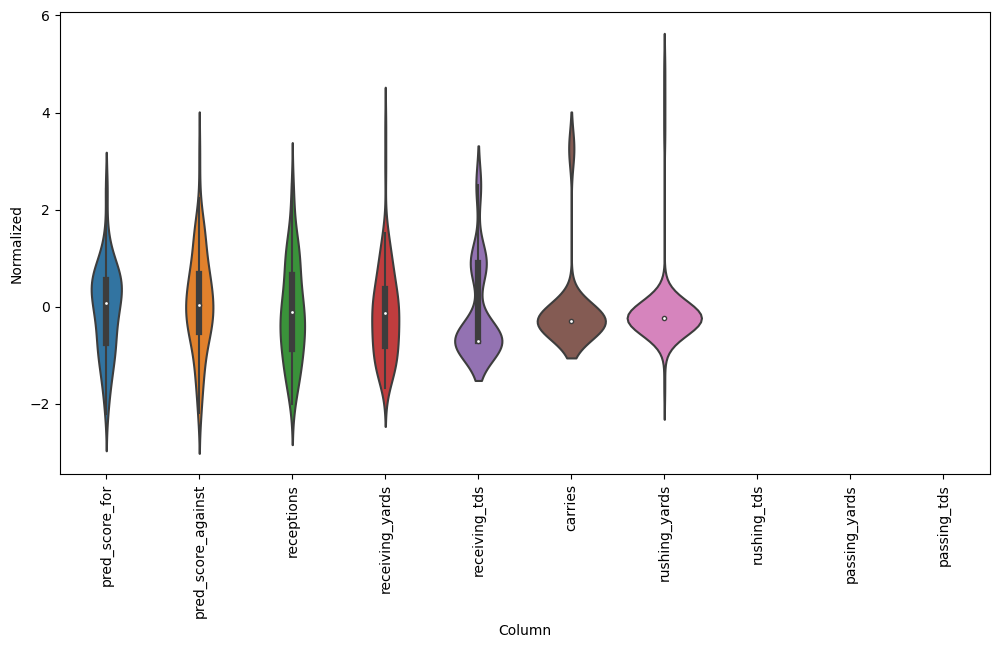

In [52]:
df_std = (df - stats_mean) / stats_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

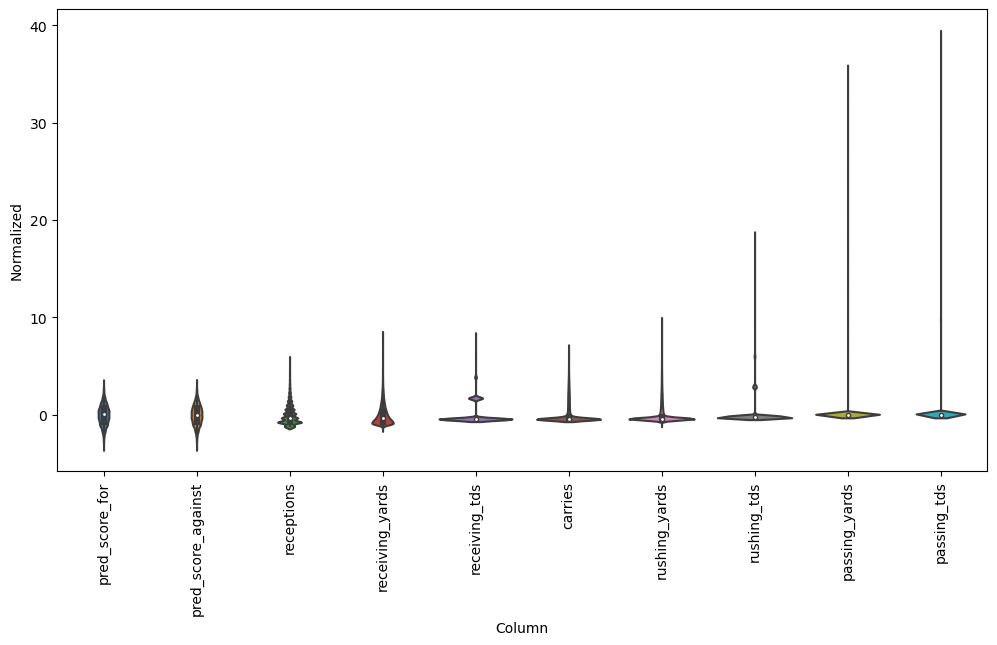

In [241]:
df_std = (testPBP._stats - testPBP._stats.mean()) / testPBP._stats.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [4]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None, shuffle = True):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.shuffle = shuffle

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='receptions', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Week')
        return
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=self.shuffle,
          batch_size=4,)

        ds = ds.map(self.split_window)

        return ds

    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [11]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['receptions'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['receptions']

In [181]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['receptions'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['receptions']

In [55]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[15:15+w2.total_window_size]),
                           np.array(train_df[30:30+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


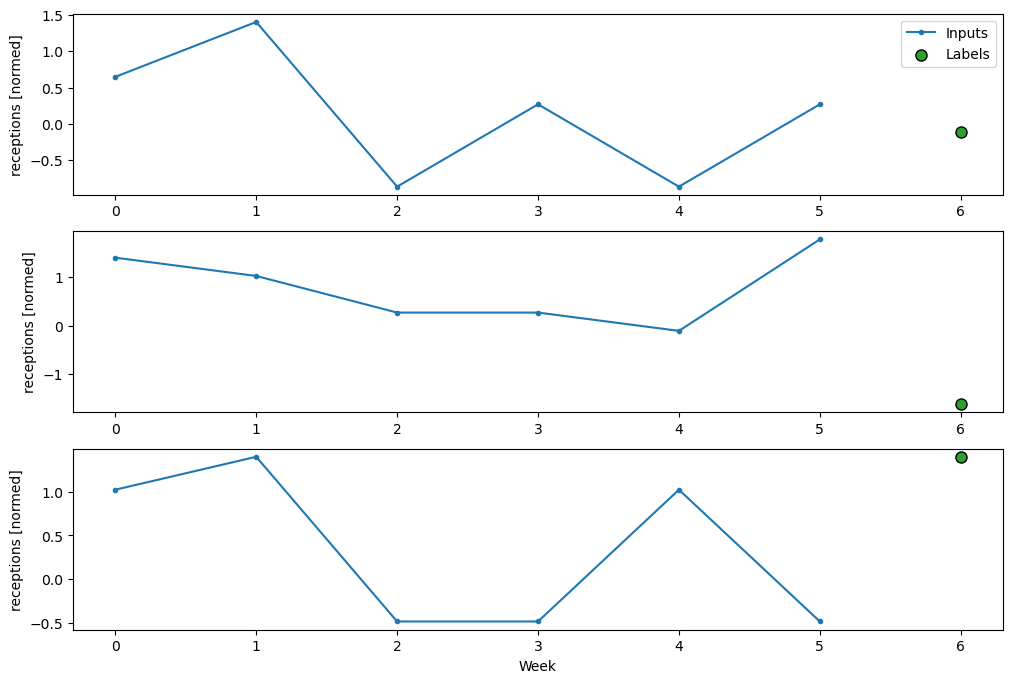

In [56]:
#w2.example = example_inputs, example_labels
w2.plot()

In [57]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [58]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['receptions'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['receptions']

In [59]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 10)
Labels shape (batch, time, features): (32, 1, 1)


In [182]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [183]:
baseline = Baseline(label_index=column_indices['receptions'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 2ms/step - loss: 1.7369 - mean_absolute_error: 1.0382


In [184]:
wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1,
    label_columns=['receptions'])

wide_window

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['receptions']

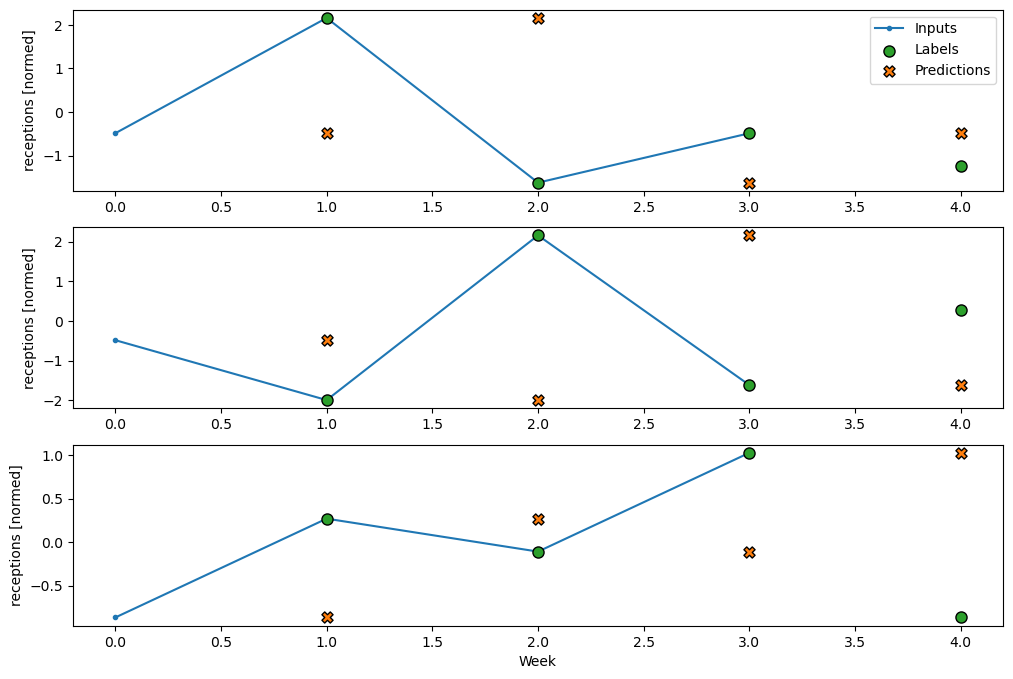

In [185]:
wide_window.plot(baseline)

In [268]:
def compile_and_fit(model, window, patience=2, compiled = False, max_epochs = 20, verbose = 1):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    if not compiled:
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=max_epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose = verbose)
    return history

In [187]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [188]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 2.5923 - mean_absolute_error: 1.2603 - val_loss: 2.3553 - val_mean_absolute_error: 1.2998
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 2.4936 - mean_absolute_error: 1.2393 - val_loss: 2.2860 - val_mean_absolute_error: 1.2808
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 2.4207 - mean_absolute_error: 1.2193 - val_loss: 2.2148 - val_mean_absolute_error: 1.2611
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 2.3353 - mean_absolute_error: 1.1986 - val_loss: 2.1528 - val_mean_absolute_error: 1.2436
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 2.2555 - mean_absolute_error: 1.1792 - val_loss: 2.0946 - val_mean_absolute_error: 1.2269
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 2.1952 - mean_absolute_error: 1.1620 - val_loss: 2.0315 - val_mean_absolute_error: 1.2082
Epoch 7/20
15/15 [=========

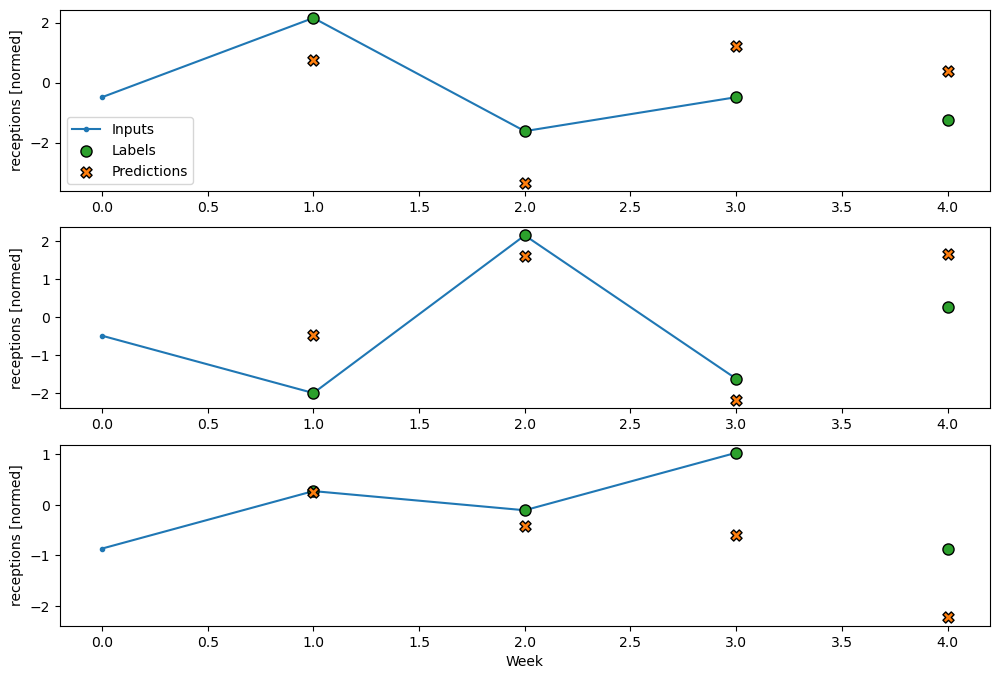

In [189]:
wide_window.plot(linear)

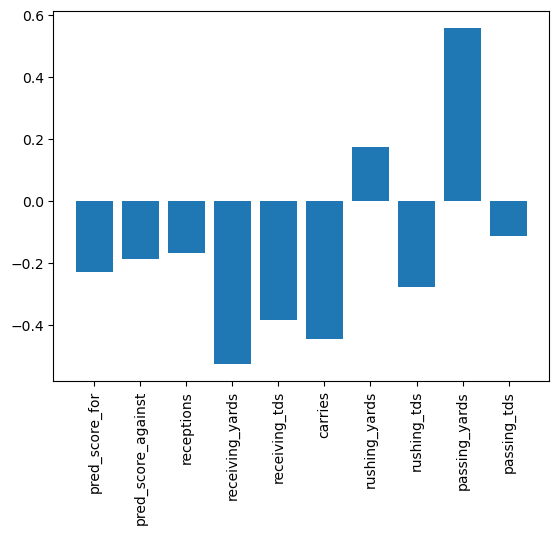

In [190]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [191]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
15/15 [==============================] - 1s 17ms/step - loss: 0.7295 - mean_absolute_error: 0.5626 - val_loss: 0.5941 - val_mean_absolute_error: 0.5211
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 0.6855 - mean_absolute_error: 0.5230 - val_loss: 0.5755 - val_mean_absolute_error: 0.5251
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 0.6616 - mean_absolute_error: 0.5173 - val_loss: 0.5604 - val_mean_absolute_error: 0.5101
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 0.6536 - mean_absolute_error: 0.5232 - val_loss: 0.5659 - val_mean_absolute_error: 0.5208
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 0.6457 - mean_absolute_error: 0.5169 - val_loss: 0.5529 - val_mean_absolute_error: 0.5059
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.6432 - mean_absolute_error: 0.5179 - val_loss: 0.5544 - val_mean_absolute_error: 0.5080
Epoch 7/20
4/4 [===========

In [192]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [193]:
wide_window.val

<MapDataset element_spec=(TensorSpec(shape=(None, 4, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4, 1), dtype=tf.float32, name=None))>

In [194]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (4, 4, 10)
Output shape: (4, 4, 1)


In [195]:
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
#val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
14/14 [==============================] - 4s 46ms/step - loss: 0.9125 - mean_absolute_error: 0.7946 - val_loss: 1.3620 - val_mean_absolute_error: 0.9742
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.8700 - mean_absolute_error: 0.7761 - val_loss: 1.3629 - val_mean_absolute_error: 0.9762
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.8359 - mean_absolute_error: 0.7606 - val_loss: 1.3729 - val_mean_absolute_error: 0.9801


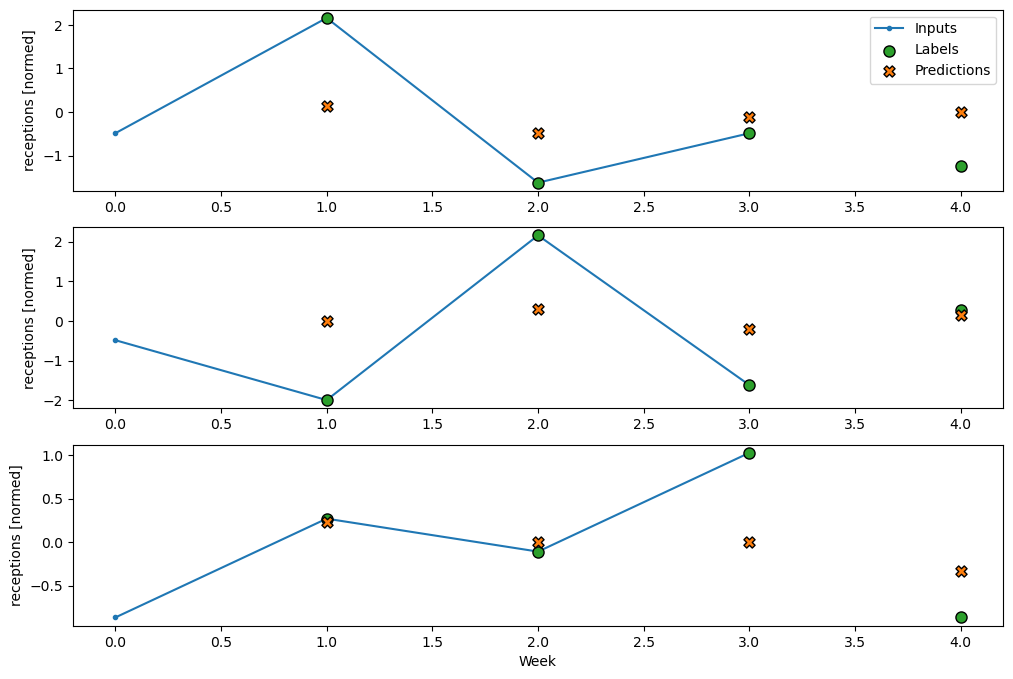

In [196]:
wide_window.plot(lstm_model)

In [197]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1)

In [198]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (4, 4, 10)
Labels shape (batch, time, features): (4, 4, 10)


In [199]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [200]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 2ms/step - loss: 1.0715 - mean_absolute_error: 0.5537


In [201]:
%%time
wide_window = WindowGenerator(
    input_width=4, label_width=4, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

Epoch 1/20
14/14 [==============================] - 3s 46ms/step - loss: 0.6966 - mean_absolute_error: 0.5212 - val_loss: 0.5380 - val_mean_absolute_error: 0.4921
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6792 - mean_absolute_error: 0.5103 - val_loss: 0.5397 - val_mean_absolute_error: 0.4935
Epoch 3/20
4/4 [==============================] - 0s 2ms/step - loss: 0.5414 - mean_absolute_error: 0.4939

CPU times: total: 2.39 s
Wall time: 3.68 s


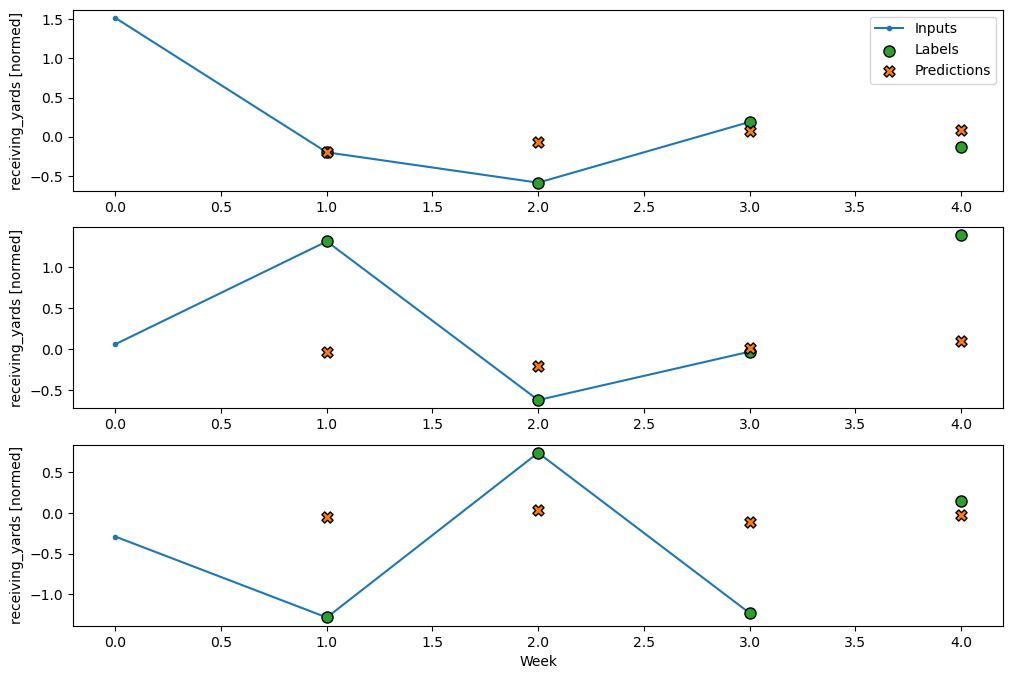

In [202]:
wide_window.plot(lstm_model, plot_col = 'receiving_yards')

In [203]:
performance['Baseline']

[0.6908482313156128, 0.40272417664527893]

In [204]:
performance['LSTM']

[0.7677880525588989, 0.6086613535881042]

In [311]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        
        
        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [250]:
labels = ['receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']

In [247]:
_JulioJ = testPBP._getPlayerFeatures('Julio Jones')

In [301]:
n = len(_JulioJ)
train_JulJ = _JulioJ[0:int(n*0.7)]
val_JulJ = _JulioJ[int(n*0.7):int(n*0.9)]
test_JulJ = _JulioJ[int(n*0.9):]

In [302]:
train_JulJ = (train_JulJ - testPBP._stats.mean()) / testPBP._stats.std()
val_JulJ = (val_JulJ - testPBP._stats.mean()) / testPBP._stats.std()
test_JulJ = (test_JulJ - testPBP._stats.mean()) / testPBP._stats.std()

In [336]:
JulJ_window = WindowGenerator(
    input_width=4, label_width=4, shift=1, train_df = train_JulJ, val_df = val_JulJ, test_df = test_JulJ, label_columns = labels)

In [335]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=len(labels))
])



In [312]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        10,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

In [254]:
num_features

10

In [ ]:
compile_and_fit(lstm_model, JulJ_window, compiled = False, max_epochs = 1000, verbose = 2, patience = 8)

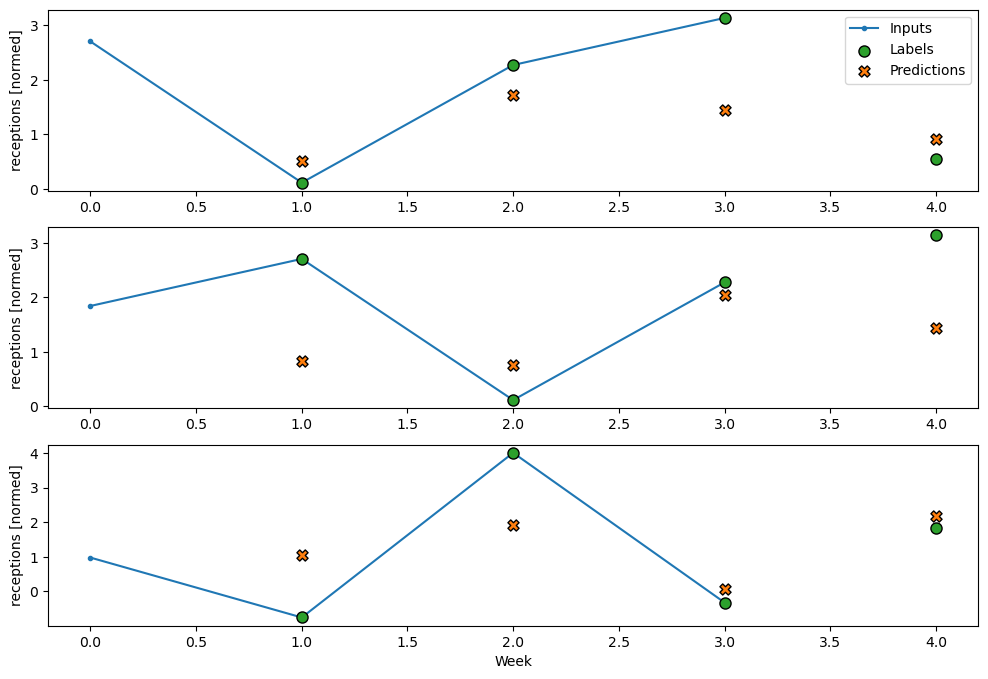

In [338]:
JulJ_window.plot(lstm_model)

In [339]:
_JJ = testPBP._getPlayerFeatures('Justin Jefferson')

In [359]:
column_indices = {name: i for i, name in enumerate(_JJ.columns)}

n = len(_JJ)
train_JJ = _JJ[0:int(n*0.7)]
val_JJ = _JJ[int(n*0.7):int(n*0.9)]
test_JJ = _JJ[int(n*0.9):]

In [360]:


train_JJ = (train_JJ - testPBP._stats.mean()) / testPBP._stats.std()
val_JJ = (val_JJ - testPBP._stats.mean()) / testPBP._stats.std()
test_JJ = (test_JJ - testPBP._stats.mean()) / testPBP._stats.std()

#train_JJ = train_JJ.fillna(0)
#val_JJ = val_JJ.fillna(0)
#test_JJ = test_JJ.fillna(0)

In [361]:
JJ_window = WindowGenerator(
    input_width=4, label_width=4, shift=1, train_df = train_JJ, val_df = val_JJ, test_df = test_JJ, label_columns = labels)

In [343]:
compile_and_fit(lstm_model, JulJ_window, compiled = True, max_epochs = 1000, verbose = 2, patience = 8)

Epoch 1/1000
5/5 - 0s - loss: 0.6152 - mean_absolute_error: 0.3791 - val_loss: 1.6512 - val_mean_absolute_error: 0.5984 - 103ms/epoch - 21ms/step
Epoch 2/1000
5/5 - 0s - loss: 0.6053 - mean_absolute_error: 0.3749 - val_loss: 1.6638 - val_mean_absolute_error: 0.5985 - 76ms/epoch - 15ms/step
Epoch 3/1000
5/5 - 0s - loss: 0.5962 - mean_absolute_error: 0.3709 - val_loss: 1.6783 - val_mean_absolute_error: 0.5994 - 76ms/epoch - 15ms/step
Epoch 4/1000
5/5 - 0s - loss: 0.5876 - mean_absolute_error: 0.3669 - val_loss: 1.6790 - val_mean_absolute_error: 0.5993 - 77ms/epoch - 15ms/step
Epoch 5/1000
5/5 - 0s - loss: 0.5770 - mean_absolute_error: 0.3624 - val_loss: 1.6959 - val_mean_absolute_error: 0.5996 - 77ms/epoch - 15ms/step
Epoch 6/1000
5/5 - 0s - loss: 0.5677 - mean_absolute_error: 0.3574 - val_loss: 1.7138 - val_mean_absolute_error: 0.5998 - 76ms/epoch - 15ms/step
Epoch 7/1000
5/5 - 0s - loss: 0.5582 - mean_absolute_error: 0.3544 - val_loss: 1.7086 - val_mean_absolute_error: 0.5996 - 76ms/ep

In [344]:
JJ_new = (_JJ[-5:-1] - testPBP._stats.mean())/ testPBP._stats.std()


In [365]:
JJ_ds  = tf.convert_to_tensor(JJ_new)

In [385]:
data = np.array(JJ_new, dtype=np.float32)
JJ_ds_2 = tf.keras.utils.timeseries_dataset_from_array(
  data=data,
  targets=None,
  sequence_length=4,
  sequence_stride=1,
  shuffle=True,
  batch_size=4,)



In [386]:
JJ_ds_2

<BatchDataset element_spec=TensorSpec(shape=(None, None, 10), dtype=tf.float32, name=None)>

In [345]:
JJ_pred = WindowGenerator(
    input_width=4, label_width=4, shift=1, train_df = JJ_new, val_df = JJ_new, test_df = JJ_new, label_columns = labels)

In [367]:
JJ_ds.shape

TensorShape([4, 10])

In [387]:
lstm_model.predict(JJ_ds_2)

1/1 [==============================] - 0s 475ms/step


array([[[ 8.3479309e-01,  1.2010074e+00,  3.0623758e-01, -3.1107908e-01,
         -3.0850515e-01, -1.4486042e-01, -2.6524898e-02, -7.5516284e-02],
        [ 1.7649626e+00,  2.9451036e+00,  1.0541301e+00, -5.1612544e-01,
         -4.0065476e-01, -1.6277114e-01,  4.7938814e-03, -1.3721287e-03],
        [ 7.8760761e-01,  1.2924736e+00, -2.8910023e-01, -4.8896325e-01,
         -3.3672288e-01, -1.7462350e-01,  7.9761237e-02,  2.5981998e-01],
        [ 1.4649621e+00,  1.9901741e+00,  1.2329860e-01, -5.7857275e-01,
         -3.7490609e-01, -1.5579857e-01, -1.9279659e-02,  6.9685042e-02]]],
      dtype=float32)

In [398]:
val_JJ

,pred_score_for,pred_score_against,receptions,receiving_yards,receiving_tds,carries,rushing_yards,rushing_tds,passing_yards,passing_tds
26053,0.541333,1.324961,0.112019,1.176277,1.713489,-0.264384,0.033221,-0.237677,-0.056128,-0.05359
26055,0.097028,0.368563,2.705882,3.459843,-0.442022,-0.264384,-0.568363,-0.237677,-0.056128,-0.05359
26057,-0.093389,0.814882,2.273571,4.262177,3.869000,-0.264384,-0.287624,-0.237677,-0.056128,-0.05359
26059,1.049110,-0.715355,0.544329,1.608303,-0.442022,-0.448783,-0.407941,-0.237677,1.641678,-0.05359
26061,0.287444,-0.587835,3.570503,4.663344,1.713489,-0.264384,-0.247518,-0.237677,-0.056128,-0.05359
26063,1.112582,-0.651595,1.841261,1.484867,1.713489,-0.264384,-0.568363,-0.237677,-0.056128,-0.05359


In [417]:
JJ_window2 = WindowGenerator(
    input_width=4, label_width=4, shift=1, train_df = train_JJ, val_df = val_JJ, test_df = test_JJ, label_columns = labels, shuffle = False)

In [418]:
for i in JJ_window2.val:
    print(i)

(<tf.Tensor: shape=(2, 4, 10), dtype=float32, numpy=
array([[[ 0.5413327 ,  1.3249607 ,  0.11201855,  1.176277  ,
          1.7134894 , -0.26438412,  0.03322097, -0.23767655,
         -0.05612825, -0.05358991],
        [ 0.09702769,  0.36856273,  2.7058818 ,  3.4598432 ,
         -0.4420216 , -0.26438412, -0.56836295, -0.23767655,
         -0.05612825, -0.05358991],
        [-0.09338874,  0.81488174,  2.2735713 ,  4.262177  ,
          3.8690004 , -0.26438412, -0.2876238 , -0.23767655,
         -0.05612825, -0.05358991],
        [ 1.0491098 , -0.715355  ,  0.5443291 ,  1.6083031 ,
         -0.4420216 , -0.44878265, -0.40794057, -0.23767655,
          1.6416782 , -0.05358991]],

       [[ 0.09702769,  0.36856273,  2.7058818 ,  3.4598432 ,
         -0.4420216 , -0.26438412, -0.56836295, -0.23767655,
         -0.05612825, -0.05358991],
        [-0.09338874,  0.81488174,  2.2735713 ,  4.262177  ,
          3.8690004 , -0.26438412, -0.2876238 , -0.23767655,
         -0.05612825, -0.05358991

In [419]:
lstm_model.predict(JJ_window2.val)

1/1 [==============================] - 0s 60ms/step


array([[[ 1.1157776 ,  1.8760343 ,  0.7396644 , -0.35613802,
         -0.30056864, -0.22269861, -0.01907736, -0.05109069],
        [ 0.65068847,  1.0272257 , -0.34363902, -0.38750443,
         -0.3640756 , -0.24355544, -0.01478812,  0.02576245],
        [ 0.96791756,  2.2751896 , -0.43996787, -0.5704432 ,
         -0.5824489 , -0.3371945 , -0.16872661, -0.02543816],
        [ 0.9146383 ,  1.7469475 , -0.5635366 , -0.38371876,
         -0.45650426, -0.40556467, -0.06194262, -0.17326158]],

       [[ 0.43547168,  0.5672064 , -0.24792767, -0.34374875,
         -0.31400743, -0.16027296, -0.01778999, -0.01354164],
        [ 0.90813136,  2.083861  , -0.34784096, -0.54900557,
         -0.53656256, -0.2730019 , -0.1580718 , -0.06571907],
        [ 0.9427017 ,  1.754564  , -0.4790725 , -0.38009205,
         -0.43830606, -0.36141348, -0.06630643, -0.19128713],
        [ 0.1879996 ,  0.42732197, -1.2031757 , -0.46700248,
         -0.41723928, -0.34729278, -0.04444972, -0.03726324]]],
      dtype=

In [420]:
JJ_vldf = pd.DataFrame([[ 0.09702769,  0.36856273,  2.7058818 ,  3.4598432 ,
         -0.4420216 , -0.26438412, -0.56836295, -0.23767655,
         -0.05612825, -0.05358991],
        [-0.09338874,  0.81488174,  2.2735713 ,  4.262177  ,
          3.8690004 , -0.26438412, -0.2876238 , -0.23767655,
         -0.05612825, -0.05358991],
        [ 1.0491098 , -0.715355  ,  0.5443291 ,  1.6083031 ,
         -0.4420216 , -0.44878265, -0.40794057, -0.23767655,
          1.6416782 , -0.05358991],
        [ 0.2874441 , -0.58783525,  3.5705028 ,  4.663344  ,
          1.7134894 , -0.26438412, -0.24751818, -0.23767655,
         -0.05612825, -0.05358991]])

JJ_vldf = pd.DataFrame( [[ 0.5413327 ,  1.3249607 ,  0.11201855,  1.176277  ,
          1.7134894 , -0.26438412,  0.03322097, -0.23767655,
         -0.05612825, -0.05358991],
        [ 0.09702769,  0.36856273,  2.7058818 ,  3.4598432 ,
         -0.4420216 , -0.26438412, -0.56836295, -0.23767655,
         -0.05612825, -0.05358991],
        [-0.09338874,  0.81488174,  2.2735713 ,  4.262177  ,
          3.8690004 , -0.26438412, -0.2876238 , -0.23767655,
         -0.05612825, -0.05358991],
        [ 1.0491098 , -0.715355  ,  0.5443291 ,  1.6083031 ,
         -0.4420216 , -0.44878265, -0.40794057, -0.23767655,
          1.6416782 , -0.05358991]])

In [409]:
JJ_vldf

,0,1,2,3,4,5,6,7,8,9
0,0.541333,1.324961,0.112019,1.176277,1.713489,-0.264384,0.033221,-0.237677,-0.056128,-0.05359
1,0.097028,0.368563,2.705882,3.459843,-0.442022,-0.264384,-0.568363,-0.237677,-0.056128,-0.05359
2,-0.093389,0.814882,2.273571,4.262177,3.869000,-0.264384,-0.287624,-0.237677,-0.056128,-0.05359
3,1.049110,-0.715355,0.544329,1.608303,-0.442022,-0.448783,-0.407941,-0.237677,1.641678,-0.05359


In [421]:
data = np.array(JJ_vldf, dtype=np.float32)
JJ_vlds_test = tf.keras.utils.timeseries_dataset_from_array(
  data=data,
  targets=None,
  sequence_length=4,
  sequence_stride=1,
  shuffle=True,
  batch_size=4,)


In [422]:
lstm_model.predict(JJ_vlds_test)

1/1 [==============================] - 0s 30ms/step


array([[[ 1.1157776 ,  1.8760343 ,  0.73966444, -0.35613805,
         -0.30056867, -0.22269857, -0.01907738, -0.05109069],
        [ 0.65068847,  1.0272257 , -0.34363905, -0.38750452,
         -0.36407566, -0.24355543, -0.01478814,  0.02576253],
        [ 0.9679175 ,  2.2751899 , -0.4399678 , -0.57044315,
         -0.58244884, -0.3371945 , -0.16872658, -0.02543819],
        [ 0.9146382 ,  1.7469478 , -0.5635366 , -0.38371876,
         -0.45650414, -0.40556473, -0.06194268, -0.17326155]]],
      dtype=float32)

In [ ]:
for i in JJ_window.train:
    print(i)
    ts_test = i

In [352]:
for i in JJ_pred.train:
    print(i)

In [348]:
JJ_window.train

<MapDataset element_spec=(TensorSpec(shape=(None, 4, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4, 8), dtype=tf.float32, name=None))>

In [354]:
JJ_pred.train

<MapDataset element_spec=(TensorSpec(shape=(None, 4, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4, 8), dtype=tf.float32, name=None))>

In [5]:
class PlayByPlay:
    def __init__(self, pbp, players):
        self.unique_players = players[["player_id", "player_name", "season"]].drop_duplicates()

        
        passers = pbp.groupby(['passer_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team', 'season'], as_index = False).agg({'passing_yards': 'sum', 'pass_touchdown':'sum'}).rename(columns = {'pass_touchdown': 'passing_tds'})
        passers = passers.merge(self.unique_players, left_on=["passer_id", 'season'], right_on=["player_id", 'season']).drop(columns = ['passer_id', 'season'])
        
        receivers = pbp.groupby(['receiver_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team', 'season'], as_index = False).agg({'complete_pass': 'sum', 'receiving_yards': 'sum', 'touchdown':'sum'}).rename(columns = {'complete_pass': 'receptions', 'touchdown': 'receiving_tds'})
        receivers = receivers.merge(self.unique_players, left_on=["receiver_id", 'season'], right_on=["player_id", 'season']).drop(columns = ['receiver_id', 'season'])
        
        rushers = pbp.groupby(['rusher_id', 'week', 'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team', 'season'], as_index = False).agg({'rush': 'sum', 'rushing_yards': 'sum', 'touchdown':'sum'}).rename(columns = {'rush': 'carries', 'touchdown': 'rushing_tds'})
        rushers = rushers.merge(self.unique_players, left_on=["rusher_id", 'season'], right_on=["player_id", 'season']).drop(columns = ['rusher_id', 'season'])
        
        playerStats = receivers.merge(rushers, on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'outer')
        playerStats = playerStats.merge(passers, on =[ 'week', 'player_name', 'player_id',  'game_date', 'spread_line', 'total_line', 'possession_team', 'home_team'], how = 'outer').fillna(0)
        playerStats['spread_line'] = playerStats['spread_line']*(-2*(playerStats['possession_team'] == playerStats['home_team']) + 1) #Turns spread into the value relative to player rather than away team
        playerStats = playerStats.drop(columns=['possession_team', 'home_team']) #No longer need to keep track of teams after fixing spread
        playerStats['pred_score_for'] = (playerStats['total_line']-playerStats['spread_line'])/2
        playerStats['pred_score_against'] = (playerStats['total_line']+playerStats['spread_line'])/2
        playerStats = playerStats[['game_date', 'week', 'player_id', 'player_name', 'pred_score_for', 'pred_score_against', 'receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']]
        self.playerStats = playerStats.sort_values(by = ['game_date'])
        self._stats = self.playerStats[['pred_score_for', 'pred_score_against', 'receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']].copy()
        self.stat_labels = ['receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']
        
        defStats = pbp.groupby(['game_date', 'week', 'defteam'], as_index=False).agg({'passing_yards': 'sum', 'pass_touchdown':'sum', 'complete_pass': 'sum', 'receiving_yards': 'sum', 'touchdown':'sum', 'rushing_yards': 'sum', 'sack':'sum', 'interception':'sum', 'fumble_lost': 'sum'})
        self.defStats = defStats.rename(columns = {'complete_pass': 'receptions', 'sack': 'sacks', 'fumble_lost': 'fumbles', 'interception': 'interceptions'})
        
        self._makeModel()
        return
    
    def getPlayer(self, name):

        return self.playerStats[self.playerStats['player_name'] == name]
    
    def _getPlayerFeatures(self, name):
        """Returns player stats, but with everything stripped except the features to train on."""
        playerFeatures = self.getPlayer(name)
        playerFeatures = playerFeatures[['pred_score_for', 'pred_score_against', 'receptions', 'receiving_yards', 'receiving_tds', 'carries', 'rushing_yards', 'rushing_tds', 'passing_yards', 'passing_tds']]
        playerFeatures[['pred_score_for', 'pred_score_against']] = playerFeatures[['pred_score_for', 'pred_score_against']].shift(-1)
        
        return playerFeatures
    
    def _makeModel(self):
        self.lstm_model = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(32, return_sequences=True),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=len(self.stat_labels))
                ])
        self.lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])
        return
    
    def _trainModel(self, patience=2, max_epochs = 20, verbose = 1):
        
        for player in self.unique_players['player_name'].sample(frac=1): #Shuffle player order
            playerdata = self._getPlayerFeatures(player)
            n = len(playerdata)
            if n < 15:
                continue
            train_df= playerdata[0:int(n*0.7)]
            val_df = playerdata[int(n*0.7):int(n*0.9)]
            test_df = playerdata[int(n*0.9):]

            train_df = (train_df - self._stats.mean()) / self._stats.std()
            val_df = (val_df - self._stats.mean()) / self._stats.std()
            test_df = (test_df - self._stats.mean()) / self._stats.std()
            
            playerdata_window = WindowGenerator(
                            input_width=3, label_width=3, shift=1, train_df = train_df, val_df = val_df, test_df = test_df, label_columns = self.stat_labels)
            
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')
            self.history = self.lstm_model.fit(playerdata_window.train, epochs=max_epochs,
                          validation_data=playerdata_window.val,
                          callbacks=[early_stopping], verbose = verbose)

        return

    def _calcfpoints(self, stats_df):
        """stats_df is a DataFrame with receptions, receiving_yards, receiving_tds, rushing_yards, rushing_tds, passing_yards, and passing_tds as column headers"""
        ppr = 0.5
        pp_passingyd = 0.04
        pp_rushingyd = 0.1
        pp_receivingyd = 0.1
        pp_td = 6
        pp_passingtd = 4
        stats_df = stats_df[-1:]
        return (pp_passingyd*stats_df['passing_yards'] + pp_passingtd*stats_df['passing_tds'] + ppr*stats_df['receptions'] + pp_receivingyd*stats_df['receiving_yards'] 
                + pp_td*stats_df['receiving_tds'] + pp_rushingyd*stats_df['rushing_yards'] + pp_td*stats_df['rushing_tds'])


    
    def _predPlayer(self, name):
        playerdata = self._getPlayerFeatures(name)[-5:-1] #Not including last point because the vegas odds are not input for those, will need to feed those in
        playerdata = (playerdata - self._stats.mean())/self._stats.std()
        if len(playerdata) < 4:
            return 0
        playerdata_tfds = tf.keras.utils.timeseries_dataset_from_array(
          data=playerdata,
          targets=None,
          sequence_length=4,
          sequence_stride=1,
          shuffle=True,
          batch_size=4,)
        
        player_pred = self.lstm_model.predict(playerdata_tfds)
        player_pred_df = pd.DataFrame(player_pred.reshape((4,8)))
        player_pred_df.columns = self.stat_labels
        player_pred_df_scaled = (player_pred_df*self._stats[self.stat_labels].std() + self._stats[self.stat_labels].mean())
        
        
        return self._calcfpoints(player_pred_df_scaled)
    
    def predictAll(self):
        fpoints = {}
        for player in self.unique_players['player_name'].sample(frac=1): #Shuffle player order
            fpoints[player] = self._predPlayer(player)
        fpoints_df = pd.DataFrame(fpoints).transpose()
        fpoints_df.columns = ['Fantasy Points']
        return fpoints_df.sort_values(by=['Fantasy Points'], ascending = False)

In [8]:
largeyears = [2008 + i for i in range(14)]
print(largeyears)

[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [9]:
pbp_largeyears = nfl.import_pbp_data(largeyears)
players_largeyears = nfl.import_rosters(largeyears)

2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
Downcasting floats.


In [6]:
PBPnew = PlayByPlay(pbp_multyears, players_multyears)

In [15]:
%%time
PBPnew._trainModel(max_epochs = 100, verbose = 0, patience = 5)

CPU times: total: 24min 58s
Wall time: 2h 51min 8s


In [9]:
fpoints = PBPnew.predictAll()

1/1 [==============================] - 0s 28ms/step


In [108]:
fpoints

,Fantasy Points
Derrick Henry,25.461454
Kenneth Farrow,24.831375
Devin Singletary,24.288143
D'Onta Foreman,23.339222
Jonathan Taylor,22.902637
...,...
Kendall Wright,-2.124743
Chris Moore,-2.379938
Shi Smith,-2.567060
Laquon Treadwell,-3.736077


In [655]:
fpoints_df = pd.DataFrame(fpoints ).transpose()

In [656]:
fpoints_df.columns = ['Fantasy Points']

In [ ]:
fpoints_df.sort_values(by=['Fantasy Points'], ascending = False)[:50]

In [720]:
PBPnew.lstm_model.save('saved_model/lstm_model')

INFO:tensorflow:Assets written to: saved_model/lstm_model\assets


INFO:tensorflow:Assets written to: saved_model/lstm_model\assets


In [7]:
new_model = tf.keras.models.load_model('saved_model/lstm_model')

In [8]:
PBPnew.lstm_model = new_model

In [19]:
fpoints_pruned = fpoints[fpoints['Fantasy Points'] > 5]

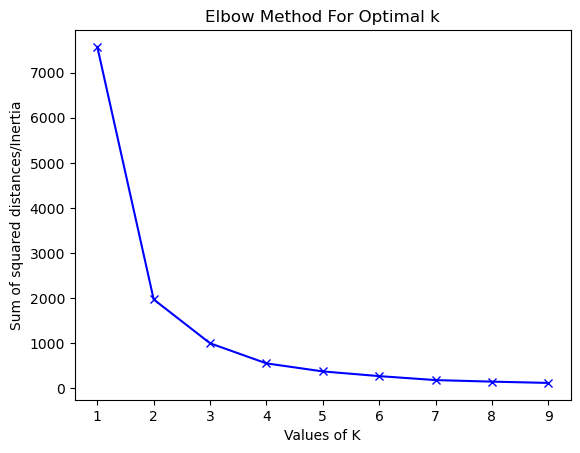

In [20]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(fpoints_pruned)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=9)
kmeans.fit(fpoints_pruned)

KMeans(n_clusters=9)

In [69]:
idx = np.argsort(-kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(9)

In [70]:
kmeans.cluster_centers_.sum(axis=1)

array([11.41681248,  6.44855635, 19.43689228, 14.20631858,  7.66283717,
       24.16456642,  9.14410996,  5.40401381, 16.81172677])

In [71]:
 np.argsort(-kmeans.cluster_centers_.sum(axis=1))

array([5, 2, 8, 3, 0, 6, 4, 1, 7], dtype=int64)

In [72]:
print(idx)
print(lut)

[5 2 8 3 0 6 4 1 7]
[4 7 1 3 6 0 5 8 2]


In [74]:
lut[kmeans.labels_]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [34]:
fpoints_labels = kmeans.labels_

In [76]:
fpoints_labeled = fpoints_pruned.copy()
fpoints_labeled['Tier'] = lut[kmeans.labels_]

In [144]:
fpoints_labeled['Position'] = players_multyears[players_multyears['player_name'] == fpoints_labeled.index]['position']

ValueError: ('Lengths must match to compare', (20546,), (429,))

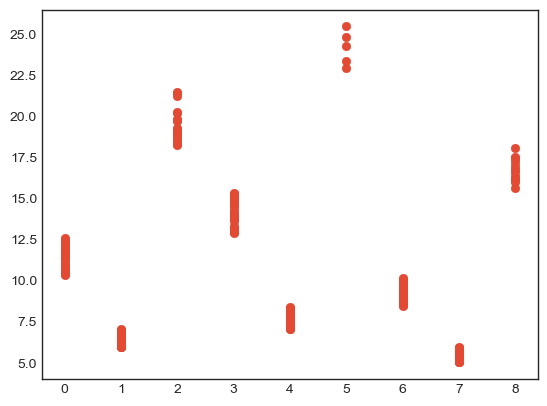

In [77]:
plt.scatter(fpoints_labels, fpoints_labeled['Fantasy Points'])

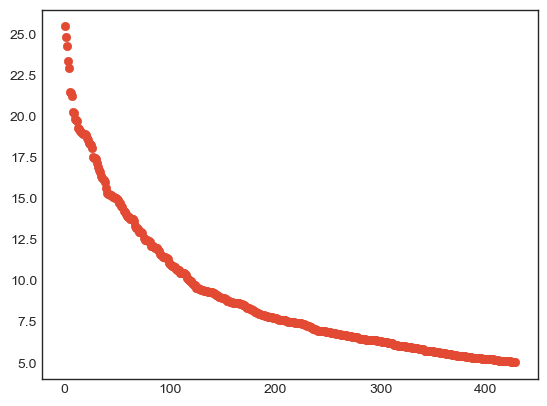

In [78]:
plt.scatter(range(len(fpoints_labeled)), fpoints_labeled['Fantasy Points'])

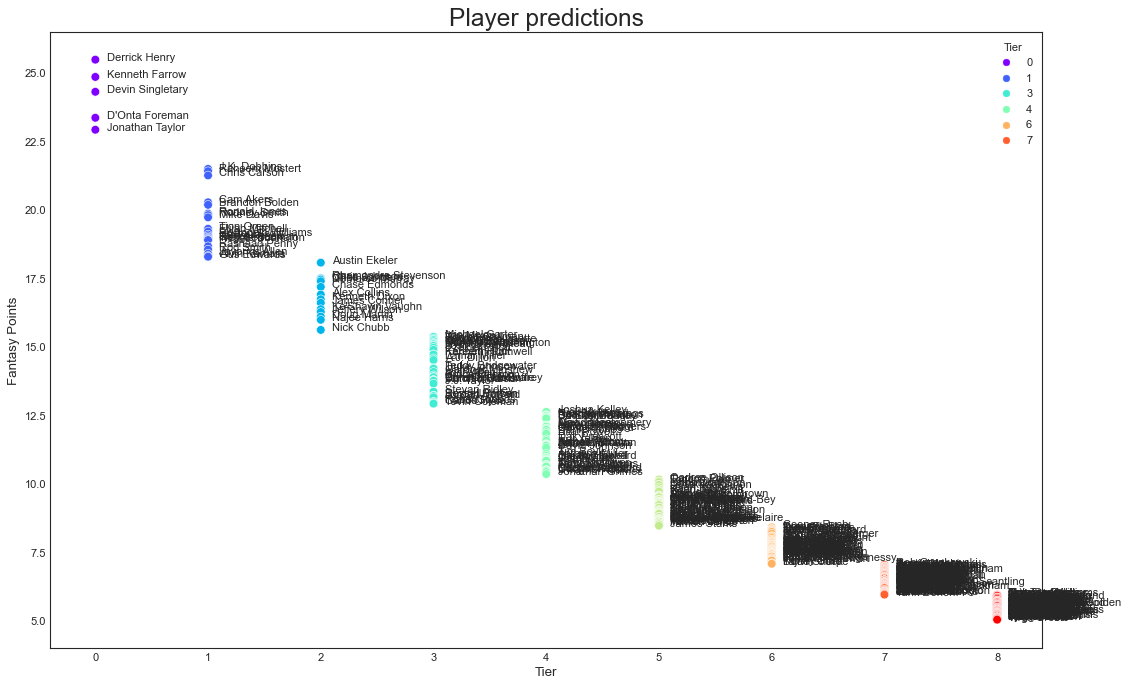

In [115]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
#snsplt = sns.stripplot(data = fpoints_labeled,  x = 'Tier', y='Fantasy Points', jitter=0.25, size=8, ax=ax, linewidth=.5, hue="Tier", palette = 'rainbow')
sns.scatterplot(data = fpoints_labeled,  x = 'Tier', y='Fantasy Points', s=60, ax=ax, linewidth=.5, hue="Tier", palette = 'rainbow')
# Decorations
#for i, name in enumerate(fpoints_labeled.index):
#    plt.annotate(name, (fpoints_labeled['Tier'][i]+0.1, fpoints_labeled['Fantasy Points'][i]+0) )
#plt.text(x=fpoints_labeled['Tier'], y=fpoints_labeled['Fantasy Points'], s=np.array(fpoints_labeled.index))
plt.title('Player predictions', fontsize=22)
plt.show()

In [ ]:
np.array(fpoints_labeled.index)

In [103]:
for p in fpoints_labeled[0:1]:
    print(p)

Fantasy Points
Tier


In [91]:
snsplt.get_offsets

AttributeError: 'AxesSubplot' object has no attribute 'get_offsets'

In [47]:
fpoints_pruned['Fantasy Points']

Derrick Henry       25.461454
Kenneth Farrow      24.831375
Devin Singletary    24.288143
D'Onta Foreman      23.339222
Jonathan Taylor     22.902637
                      ...    
Travis Homer         5.054231
Reggie Bush          5.051191
Tyron Johnson        5.050325
Josh Malone          5.030278
Virgil Green         5.013588
Name: Fantasy Points, Length: 429, dtype: float64

In [124]:
test = fpoints_labeled.reset_index().rename(columns = {'index': 'Player'})

In [131]:
test['Ranking'] = -test.index

In [132]:
test

,Player,Fantasy Points,Tier,Ranking
0,Derrick Henry,25.461454,0,0
1,Kenneth Farrow,24.831375,0,-1
2,Devin Singletary,24.288143,0,-2
3,D'Onta Foreman,23.339222,0,-3
4,Jonathan Taylor,22.902637,0,-4
...,...,...,...,...
424,Travis Homer,5.054231,8,-424
425,Reggie Bush,5.051191,8,-425
426,Tyron Johnson,5.050325,8,-426
427,Josh Malone,5.030278,8,-427


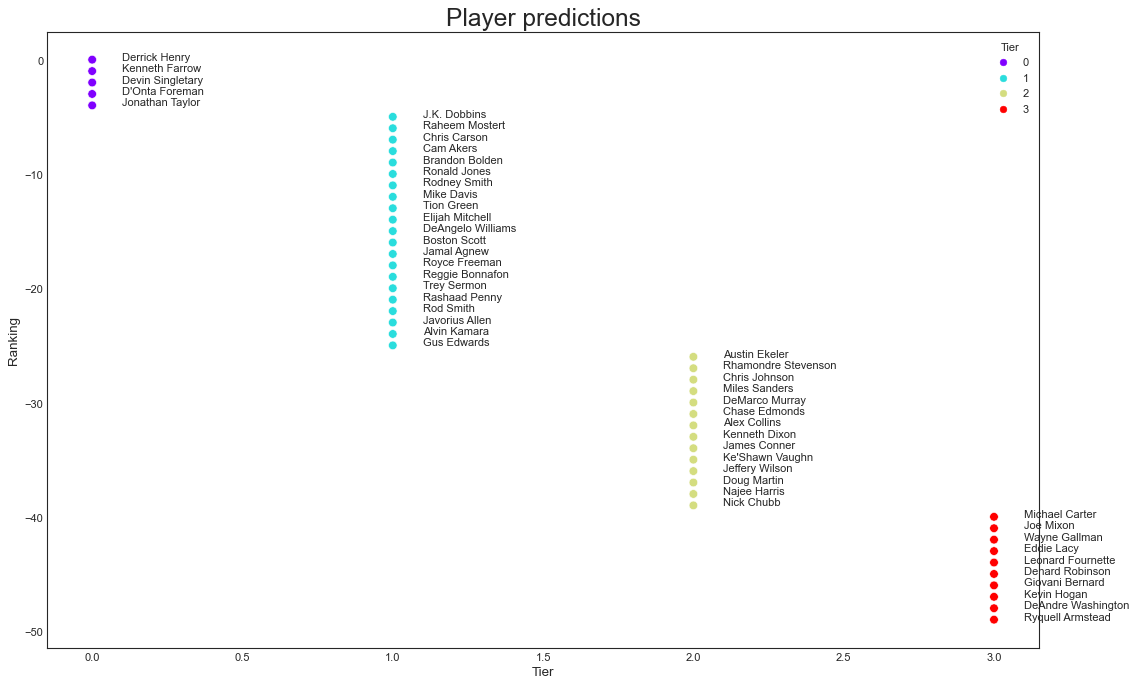

In [135]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
#snsplt = sns.stripplot(data = fpoints_labeled,  x = 'Tier', y='Fantasy Points', jitter=0.25, size=8, ax=ax, linewidth=.5, hue="Tier", palette = 'rainbow')
sns.scatterplot(data = test[:50],  x = 'Tier', y='Ranking', s=60, ax=ax, linewidth=.5, hue="Tier", palette = 'rainbow')
# Decorations
for i, name in enumerate(test[:50]['Player']):
    plt.annotate(name, (test[:50]['Tier'][i]+0.1, test[:50]['Ranking'][i]+0) )
#plt.text(x=fpoints_labeled['Tier'], y=fpoints_labeled['Fantasy Points'], s=np.array(fpoints_labeled.index))
plt.title('Player predictions', fontsize=22)
plt.show()

In [143]:
players_multyears#.position.unique()

,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,...,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number
0,2014,ARZ,C,None,63,Active,Lyle Sendlein,Lyle,Sendlein,1984-03-16,...,WC,A01,Lyle,SEN108904,NaN,NaN,2007,2007,None,None
1,2014,ARZ,CB,None,28,Active,Justin Bethel,Justin,Bethel,1990-06-17,...,WC,A01,Justin,BET201235,NaN,NaN,2012,2012,ARZ,27
2,2014,ARZ,CB,None,31,Active,Antonio Cromartie,Antonio,Cromartie,1984-04-15,...,WC,A01,Antonio,CRO161100,NaN,NaN,2006,2006,SD,201
3,2014,ARZ,CB,None,21,Active,Patrick Peterson,Patrick,Peterson,1990-07-11,...,WC,A01,Patrick,PET415511,NaN,NaN,2011,2011,None,None
4,2014,ARZ,CB,None,25,Active,Jerraud Powers,Courtney,Powers,1987-07-19,...,WC,A01,Jerraud,POW641973,NaN,NaN,2009,2009,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2691,2021,WAS,WR,WR,17.0,Active,Terry McLaurin,Terry,McLaurin,1995-09-15,...,REG,A01,Terry,MCL278328,47859,32004d43-4c27-8328-8097-b130ba0e8060,2019,2019.0,WAS,76.0
2692,2021,WAS,WR,WR,13.0,PS; Exc,Kelvin Harmon,Kelvin,Harmon,1996-12-15,...,REG,P06,Kelvin,HAR206185,47989,32004841-5220-6185-a2b0-6140674f568a,2019,2019.0,WAS,206.0
2693,2021,WAS,WR,WR,18.0,Practice Squad,Antonio Gandy-Golden,Antonio,Gandy-Golden,1998-04-11,...,REG,P01,Antonio,GAN139028,52550,32004741-4e13-9028-ffdd-34109916cfd5,2020,2020.0,WAS,142.0
2694,2021,WAS,WR,WR,2.0,Active,Dyami Brown,Dyami,Brown,1999-11-01,...,REG,A01,Dyami,BRO408220,53511,32004252-4f40-8220-1974-8f5000372de2,2021,2021.0,WAS,82.0


In [155]:
test.merge(players_multyears[['player_name', 'position']].drop_duplicates(), left_on = 'Player', right_on = 'player_name').drop(columns = 'player_name')

,Player,Fantasy Points,Tier,Ranking,position
0,Derrick Henry,25.461454,0,0,RB
1,Kenneth Farrow,24.831375,0,-1,RB
2,Devin Singletary,24.288143,0,-2,RB
3,D'Onta Foreman,23.339222,0,-3,RB
4,Jonathan Taylor,22.902637,0,-4,RB
...,...,...,...,...,...
453,Travis Homer,5.054231,8,-424,RB
454,Reggie Bush,5.051191,8,-425,RB
455,Tyron Johnson,5.050325,8,-426,WR
456,Josh Malone,5.030278,8,-427,WR


In [157]:
test

,Player,Fantasy Points,Tier,Ranking
0,Derrick Henry,25.461454,0,0
1,Kenneth Farrow,24.831375,0,-1
2,Devin Singletary,24.288143,0,-2
3,D'Onta Foreman,23.339222,0,-3
4,Jonathan Taylor,22.902637,0,-4
...,...,...,...,...
424,Travis Homer,5.054231,8,-424
425,Reggie Bush,5.051191,8,-425
426,Tyron Johnson,5.050325,8,-426
427,Josh Malone,5.030278,8,-427


In [147]:
self.unique_players = players[["player_id", "player_name", "season"]].drop_duplicates()

NameError: name 'passers' is not defined